In [790]:
import gzip
import pickle 
import numpy as np

def load(agent_name):
    assert agent_name in ('strong_branching', 'pseudocost_branching', 'il', 'retro', 'random', 'topk', 'topk_il')

    return pickle.load(
        gzip.open(
            f'../../retro_branching_paper_validation_agents/crabs_n_time_12_n_resources_20_n_ships_35'
            f'/{agent_name}/rl_validator/rl_validator_1/checkpoint_64/episodes_log.pkl'
        ))


load('topk_il')

{'topk': defaultdict(list,
             {'action_probabilities': [[],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],
               [],

In [792]:
def read_stats(agent_name):
    data = load(agent_name)
    # name inside .pkl 
    agent_name = data['agent_names'][0]
    nodes = data[agent_name]['num_nodes']
    lps = data[agent_name]['lp_iterations']
    time = data[agent_name]['solving_time']
    return {
        'nodes': [np.abs(np.sum(val)) for val in nodes],
        'lps': [np.abs(np.sum(val)) for val in lps],
        'time': [np.abs(np.sum(val)) for val in time],
    }
    

dat = read_stats('topk_il')
print(f'#LPs: {np.median(dat["lps"]):.4} +- {np.std(dat["lps"]):.4}')
print('#Nodes: ', f'{np.median(dat["nodes"]):.4} +- {np.std(dat["nodes"]):.4}')
print('quantiles: ', np.quantile(dat["nodes"], [0.25, 0.5, 0.75, 0.95]))

#np.mean(sorted(val)[:int(len(val) * 0.95)])

#LPs: 988.0 +- 1.023e+04
#Nodes:  8.0 +- 40.28
quantiles:  [ 4.   8.  14.  71.9]


### strong branching 
#Nodes:  6.0 +- 54.25  
quantiles:  [ 3. 14. 81.]  
#LPs: 951.0 +- 1.262e+04  


### dqn trained
#Nodes:  9.0 +- 78.53  
quantiles:  [ 8. 17. 66.]  
#LPs: 1.03e+03 +- 1.468e+04  


### random
#Nodes:  10.0 +- 333.1  
quantiles:  [  7.  33. 172.]  
#LPs: 860.0 +- 2.183e+04  


pp plot

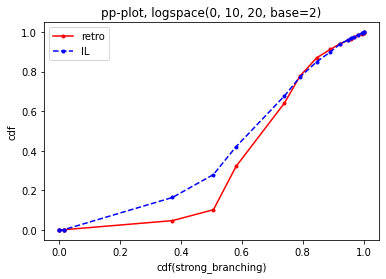

In [701]:
from matplotlib import pyplot as plt

def cdf():
    strong_data = sorted(read_stats('strong_branching')['nodes'])
    #rng = np.linspace(strong_data[0], strong_data[-1], 20)
    rng = np.logspace(0, 10, 20, base=2)
    strong_probs = np.searchsorted(strong_data, rng, 'right') / len(strong_data)

    retro_data = sorted(read_stats('retro')['nodes'])
    retro_probs = np.searchsorted(retro_data, rng, 'right') / len(retro_data)
    
    il_data = sorted(read_stats('il')['nodes'])
    il_probs = np.searchsorted(il_data, rng, 'right') / len(il_data)
    
    return (strong_probs, retro_probs, il_probs)

x, y_retro, y_il = cdf()
plt.plot(x, y_retro, marker='.', color='red', label='retro')
plt.plot(x, y_il, marker='.', color='blue', linestyle='--', label='IL')
plt.xlabel('cdf(strong_branching)')
plt.ylabel('cdf')
plt.title('pp-plot, logspace(0, 10, 20, base=2)')
plt.legend()
plt.savefig('pp_retro.pdf')

plt.show()
    

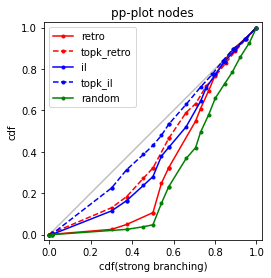

In [798]:
import numpy as np
from numpy import ndarray
from collections import Counter

def pp_curve(*, x: ndarray, y: ndarray, num: int = None) -> tuple[ndarray, ndarray]:
    """Build threshold-parameterized pipi curve."""
    # sort each sample for fast O(\log n) eCDF queries by `searchsorted`
    x, y = np.sort(x), np.sort(y)

    # pool sorted samples them to get thresholds
    xy = np.concatenate((x, y))
    if num is None:
        # finest detail thresholds: sort the pooled samples (sorted
        #  arrays can be merged in O(n), but it turns out numpy does
        #  not have the procedure)
        xy.sort()

    else:
        # coarsen by finding threshold grid in the pooled sample, that
        #  is equispaced after being transformed by the empirical cdf.
        xy = np.quantile(xy, np.linspace(0, 1, num=num))

    # we build the pp-curve the same way as we build the ROC curve:
    #  by parameterizing with the a monotonic threshold sequence
    #    pp: v \mapsto (\hat{F}_x(v), \hat{F}_y(v))
    #  where \hat{F}_S(v) = \frac1{n_S} \sum_j 1_{S_j \leq v}
    p = np.searchsorted(x, xy) / len(x)
    q = np.searchsorted(y, xy) / len(y)

    return p, q


fig, ax = plt.subplots()
key = 'nodes' #time

x = read_stats('strong_branching')[key]
y_retro = read_stats('retro')[key]
y_il = read_stats('il')[key]
y_rnd = read_stats('random')[key]
y_topk_dqn = read_stats('topk')[key]
y_topk_il = read_stats('topk_il')[key]


ax.plot(*pp_curve(x=x, y=y_retro, num=20), label='retro', marker='.', color='red')
ax.plot(*pp_curve(x=x, y=y_topk_dqn, num=20), label='topk_retro', marker='.', color='red', linestyle='--')

ax.plot(*pp_curve(x=x, y=y_il, num=20), label='il', marker='.', color='blue')
ax.plot(*pp_curve(x=x, y=y_topk_il, num=20), label='topk_il', marker='.', color='blue', linestyle='--')

ax.plot(*pp_curve(x=x, y=y_rnd, num=20), label='random', marker='.', color='green')


ax.plot((0, 1), (0, 1), c="k", zorder=10, alpha=0.25)
ax.set_xlim(-0.025, 1.025)
ax.set_ylim(-0.025, 1.025)
ax.set_aspect(1.)
ax.legend()
ax.set_xlabel('cdf(strong branching)')
ax.set_ylabel('cdf')
ax.set_title(f'pp-plot {key}')

fig.savefig(f'pp_plot_{key}.pdf')

 ### Capacitated Facility Location


|      |    40x40 |
| :--- |                   :---:    |
|method|      LPs / Nodes       |
|SB    |        1264 / 18        |
|PB    |       1518 / 26        |
|IL    |       1794 / 36        |
|RL    |    1448 / 22        |
|Random|   1894 / 30        |


|      | 5x5               |10x10                 | 20x20                             |    40x40 |
| :--- |    :----:         |                 :---: |                 :---:             |                  :---:    |
|method| LPs / Nodes       |     #LPs / Nodes      |            LPs / Nodes            |         LPs / Nodes       |
|SB    | 5.2  / 2.0        |      44.6 / 3.2       |            379 / 9.8              |        3046 / 48.6        |
|PB    | 5.3 / 2.2         |      50.4 / 4.1       |            512 / 13.4             |        4525 / 60.0        |
|IL    | 5.0 / 2.2         |      54.3 / 5.1       |            557 / 16.5             |        5348 / 76.4        |
|RL    | 4.8 / 2.2         |      52.0 / 4.3       |            475 / 12.6             |        4935 / 60.2        |
|Random| 4.6 / 2.2         |      52.7 / 4.5       |            539 / 13.6             |        5202 / 66.8        |


In [251]:
import pandas as pd
import sqlite3 
from sqlitedict import SqliteDict


con = sqlite3.connect('../../outputs/2022-09-14/07-44-42/outputs/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_0/database/epochs_log.sqlite')
df = pd.read_sql_query("SELECT * FROM unnamed", con)



df

key                                              value
0             agent_name  b'\x80\x04\x95\x0b\x00\x00\x00\x00\x00\x00\x00...
1           agent_reward  b'\x80\x04\x95\x19\x00\x00\x00\x00\x00\x00\x00...
2           agent_device  b'\x80\x04\x95\n\x00\x00\x00\x00\x00\x00\x00\x...
3             batch_size                                  b'\x80\x04K\x01.'
4                     lr  b'\x80\x04\x95\n\x00\x00\x00\x00\x00\x00\x00G?...
5                  gamma  b'\x80\x04\x95\n\x00\x00\x00\x00\x00\x00\x00G?...
6   threshold_difficulty                                      b'\x80\x04N.'
7           learner_name  b'\x80\x04\x95\x0f\x00\x00\x00\x00\x00\x00\x00...
8                 reward  b'\x80\x04\x95\xdcU\x00\x00\x00\x00\x00\x00]\x...
9              td_target  b'\x80\x04\x95\xdcU\x00\x00\x00\x00\x00\x00]\x...
10               q_value  b'\x80\x04\x95\xdcU\x00\x00\x00\x00\x00\x00]\x...
11                  loss  b'\x80\x04\x95\xdcU\x00\x00\x00\x00\x00\x00]\x...
12            num_epochs  b'\x80\x04\x95\xae\n\x00\x00\x00\x00\x00\x00]\...
13          num_episodes  b'\x80\x04\x95\x97\n\x00\x00\x00\x00\x00\x00]\...
14       num_actor_steps  b'\x80\x04\x95\xaa\x0b\x00\x00\x00\x00\x00\x00...
15       episode_counter  b'\x80\x04\x95\x04\x00\x00\x00\x00\x00\x00\x00...
16         epoch_counter  b'\x80\x04\x95\x04\x00\x00\x00\x00\x00\x00\x00...

num_steps 61
extrinsic_R 61
R 61
episode_run_time 61
num_nodes 61
solving_time 61
lp_iterations 61
epsilon 61
per_beta 61
elapsed_training_time 61
num_epochs 61
num_episodes 61
num_actor_steps 61
agent_name 7
agent_reward 21
agent_device 6
batch_size 1 is not list
lr 0.0001 is not list
gamma 0.99 is not list
threshold_difficulty None is not list
learner_name 11
[49215.0, 47578.0, 36568.0, 46505.0, 33633.0, 33285.0, 30315.0, 46445.0, 39596.0, 28253.0, 6483.0, 54599.0, 18451.0, 1132.0, 41078.0, 39357.0, 51428.0, 52368.0, 49779.0, 53751.0, 44801.0, 49462.0, 38554.0, 25636.0, 43910.0, 3259.0, 47949.0, 27210.0, 44694.0, 36925.0]


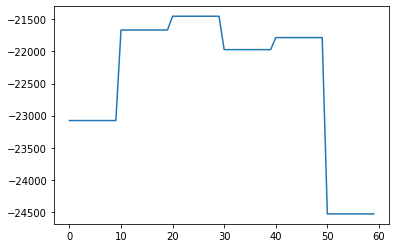

In [447]:
from matplotlib import pyplot as plt
import numpy as np


def aver(x, wind=20):
    res = []
    med = []
    for i, v in enumerate(x):
        med.append(v)
        if i > 0 and i % wind == 0:
            res.extend([np.median(med)] * wind)
            med = []
    return res

with SqliteDict('../../outputs/2022-09-16/12-44-31/outputs/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_0/database/episodes_log.sqlite') as log:
    for key, val in log.items():
        try:
            print(key, len(val))
        except:
            print(key, val, 'is not list')
            pass
    plt.plot(aver(log['R'], wind=10))
    print(log['num_nodes'][:30])


In [404]:
import subprocess
import gzip
import pickle 
import numpy as np


for i in (15722,):
    subprocess.run(
        'cp '
        f'../../outputs/2022-09-15/16-50-48/outputs/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_0/checkpoint_{i}/* '
        '../../retro_branching_paper_validation_agents/crabs_n_time_12_n_resources_20_n_ships_35/retro/',
        shell=True)
    
    # subprocess.run('source ~/.bash_profile && cd ../../ && yes | python3 experiments/validator.py --config-path=configs --config-name=validator.yaml', shell=True)
    
    dat = pickle.load(
    gzip.open(
        f'../../retro_branching_paper_validation_agents/crabs'
        f'/retro/rl_validator/rl_validator_1/checkpoint_10/episodes_log.pkl'
    ))
    
    lp_iters = dat['retro']['lp_iterations']
    val = []
    for it in lp_iters:
        val.append(np.abs(np.sum(it)))

    with open('res.txt', 'a') as f:
        f.write(f'{i} {np.median(val):.4} +- {np.std(val):.4} ')

    print(f'{np.median(val):.4} +- {np.std(val):.4}', end='; ')


    num_nodes = dat['retro']['num_nodes']
    val = []
    for node in num_nodes:
        val.append(np.abs(np.sum(node)))

    print(f'{np.median(val):.4} +- {np.std(val):.4}')
    
    with open('res.txt', 'a') as f:
        f.write(f'{np.median(val):.4} +- {np.std(val):.4}\n')
        f.flush()



pressed CTRL-C 1 times (5 times for forcing termination)


KeyboardInterrupt: 